In [13]:
import sys, os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
import openbabel
import pybel
from pybel import ob

Figures and Tables

In [47]:
# Biphenyl Example
biphenyl = pybel.readfile("cml", os.getcwd() + "/molecules/biphenyl.cml").next()

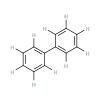

In [48]:
# Print Mol
biphenyl

In [7]:
# Force Field: MMFF94
ff = pybel._forcefields['mmff94']

def energy():
    return ff.Energy(False)

In [32]:
x = np.linspace(0,2*math.pi, 200).reshape([200,1])

rl = ob.OBRotorList()
rl.Setup(biphenyl.OBMol)
ff.Setup(biphenyl.OBMol)
currentCoords = biphenyl.OBMol.GetCoordinates()
rotIterator = rl.BeginRotors()
rotor = rl.BeginRotor(rotIterator)  # first rotatable bond
rotors = []
angles = []  # in radians
while rotor is not None:
    angle = rotor.CalcTorsion(currentCoords)
    angles.append(angle)
    rotors.append(rotor)
    rotor = rl.NextRotor(rotIterator)

def calculate_energy(torsion_angles):
    ff = pybel._forcefields['mmff94']
    output = []
    for j in range(torsion_angles.shape[0]):
        for i in range(torsion_angles.shape[1]):
            rotors[i].SetToAngle(currentCoords, torsion_angles[j,i])
            biphenyl.OBMol.SetCoordinates(currentCoords)
            ff.SetCoordinates(biphenyl.OBMol)
        output.append(ff.Energy())
    return np.array(output).reshape([torsion_angles.shape[0],1])

biphenyl_energy = calculate_energy(x)

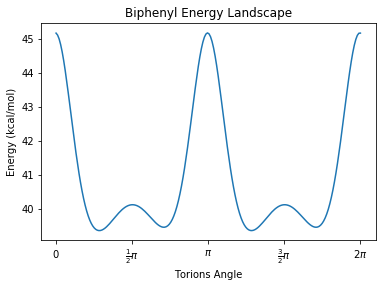

In [46]:
# Plot -- Simulated Energy Landscape 
plt.plot(x, biphenyl_energy)
plt.xticks([0, math.pi/2, math.pi, 3*math.pi/2, 2*math.pi],
           ["$0$", r"$\frac{1}{2}\pi$", r"$\pi$", r"$\frac{3}{2}\pi$", r"$2\pi$"])
plt.ylabel("Energy (kcal/mol)")
plt.xlabel("Torions Angle")
plt.title("Biphenyl Energy Landscape")
plt.show()

In [2]:
# Load Files
sets = ['one', 'two', 'three', 'four', 'five', 'six']
early_stop_file =  [pd.read_csv(os.getcwd() + "/result/summary/{}_iter_summary.txt".format(x)) for x in sets]
lowest_point_file =  [pd.read_csv(os.getcwd()+ "/result/summary/{}_lowest_point.txt".format(x)) for x in sets]

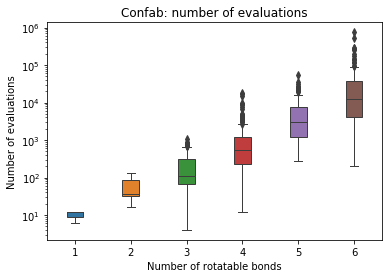

In [3]:
# Number of evaluations in Confab
# Read File and Concatenate
confab = [pd.read_csv(os.getcwd() + "/result/confab_no_evaluation/{}_confab_no.txt".format(x)) for x in sets]
concatenate_confab = pd.concat(confab, axis=0)
no_rot_bonds_list = [[i+1]*len(confab[i]) for i in range(6)]
no_rot_bonds = [item for sublist in no_rot_bonds_list for item in sublist]
concatenate_confab["No_Rotor"] = no_rot_bonds

# Violin Plot
fig, ax = plt.subplots()
ax.set(xscale='linear', yscale="log")
sns.boxplot(data=concatenate_confab, x = "No_Rotor", y = "Number", linewidth=1, width=.3)
plt.xlabel("Number of rotatable bonds")
plt.ylabel(r"Number of evaluations")
plt.title("Confab: number of evaluations")
plt.style
plt.show()

In [22]:
# Load Energy Difference File
seeds = [321, 123, 234, 345, 456] 
seeds_four = [321, 1234,2345,3456,4567]
one_energy = [pd.read_csv(os.getcwd() + "/result/energy/one_{}.txt".format(x)) for x in seeds]
two_energy = [pd.read_csv(os.getcwd() +"/result/energy/two_{}.txt".format(x)) for x in seeds]
three_energy = [pd.read_csv(os.getcwd() + "/result/energy/three_{}.txt".format(x)) for x in seeds]
four_energy = [pd.read_csv(os.getcwd() + "/result/energy/four_{}.txt".format(x)) for x in seeds_four]
five_energy = [pd.read_csv(os.getcwd() + "/result/energy/five_{}.txt".format(x)) for x in seeds]
six_energy = [pd.read_csv(os.getcwd() + "/result/energy/six_{}.txt".format(x)) for x in seeds]



In [23]:
# Energy Table Example
# Uniform / EI / LCB shows the energy difference between 
# lowest energy conformation found by Confab and the conformation found by the 
# BO/uniform search
# MMFF94 is used for energy evaluation
one_energy[1].head()

,Target,Uniform,EI,LCB,N_rot
0,astex_1hq2,1.177558,-0.009270,-0.009201,1
1,astex_1p2y,8.626438,-0.005136,-0.005127,1
2,omegapdb_1xge,6.987051,-1.637241,-1.637272,1
3,astex_1xoz,51.979654,-0.255194,-0.255042,1
4,omegapdb_1yc5,4.691540,-0.041488,-0.041639,1


In [52]:
# Remove mol with early stopping in BO search
def remove_early_stopping(energy_file, early_stop_file):
    temp = list(map(lambda x: pd.merge(x, early_stop_file, on='Target'), energy_file))
    output = list(map(lambda x: x[x["Early_Stop"]== 'No'], temp))
    return output

energy_all =  [one_energy, two_energy, three_energy, four_energy, five_energy, six_energy]
energy_all_clean = []
for indx, item in enumerate(energy_all):
    energy_all_clean.append(remove_early_stopping(item, early_stop_file[indx]))

In [ ]:
# Energy Difference
# Use seed 321 for this plot
energy_seed_321 = [item[0] for item in energy_all_clean]

energy_difference = []
for item in energy_seed_321:
    temp = pd.melt(item, id_vars=['N_rot'], value_vars=["EI", "LCB"]) 
    temp.columns = ["N_rot", "Method", "Energy_Difference"]
    energy_difference.append(temp)
                     

energy_difference_frame = pd.concat(energy_difference, axis=0)

In [44]:
# Plot
sns.violinplot(data=energy_difference_frame, x="N_rot", y="Energy_Difference", hue="Method", cut=0)
# No energy difference
plt.hlines(y=0, xmin=-.5, xmax=8.5, color='red', linestyles= "--", label='No Difference') 
# median energy difference -- N_rot = 1  (uniform random search)
plt.hlines(y=4.17, xmin=-0.5, xmax=0.5, label="Uniform (median)") 
#plt.hlines() # median energy difference -- N_rot = 1  (uniform random search)
#plt.hlines() # median energy difference -- N_rot = 1  (uniform random search)
#plt.hlines() # median energy difference -- N_rot = 1  (uniform random search)
#plt.hlines() # median energy difference -- N_rot = 1  (uniform random search)
plt.title("Energy Difference in different search algorithms")
plt.legend(loc = 'upper left')
plt.ylabel(r"$\Delta E$ (kcal/mol)")
plt.xlabel("Number of rotatable bonds")

NameError: name 'energy_difference_frame' is not defined

In [67]:
# "Champion Rate"
# Percentage of molecules that BO and Uniform search recover in each trial
def count_better_conformation(inputs):
    temp = inputs.iloc[:,1:4] <= 0
    output = temp.sum(axis=0)
    return output

# Count number of better conformations found in each trial
outputs = []
for item in energy_all_clean:
    outputs.append(list(map(lambda x: count_better_conformation(x)*100/len(x), item)))

all_count = []
for indx, item in enumerate(outputs):
    temp = pd.DataFrame(item)
    temp["N_rot"] = indx + 1
    all_count.append(temp)
    
dataframe = []
for item in all_count:
    temp = pd.melt(item, id_vars=['N_rot'], value_vars=["Uniform","EI", "LCB"])
    temp.columns = ["N_rot", "Method", "Percentage"]
    dataframe.append(temp)
    
concatenate_dataframe = pd.concat(dataframe, axis=0)

Text(0,0.5,'Percentage (%)')

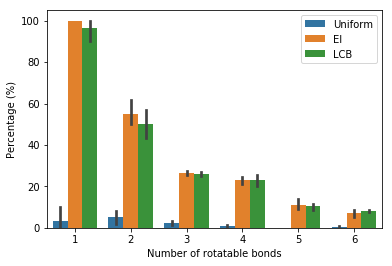

In [74]:
# Plot
sns.barplot(data=concatenate_dataframe, x='N_rot', y='Percentage', hue='Method')
plt.legend(loc = "upper right")
#plt.title()
plt.xlabel("Number of rotatable bonds")
plt.ylabel(r"Percentage (%)")

Text(0.5,0,'Number of rotatable bonds')

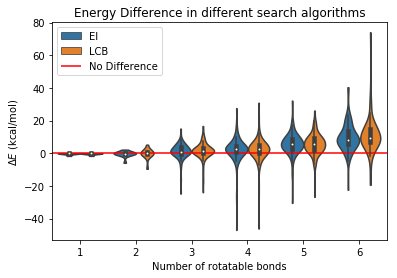

In [ ]:
# Wilcoxon Signed Rank Test (Energy Difference)

Figures and Tables in Supporting Information

In [ ]:
# RMSD Plot

In [ ]:
# Wilcoxon Signed Rank Test (RMSD)

In [ ]:
# TFD Plot

In [ ]:
# Wilcoxon Signed Rank Test (TFD)